In [55]:
!pip install gensim

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import warnings
warnings.simplefilter("ignore")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving emotion.csv to emotion (1).csv


In [4]:
df = pd.read_csv('emotion.csv')
df.head(10)


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [5]:
df.shape

(40000, 3)

In [6]:
# drop tweet_id column
df.drop('tweet_id', axis=1, inplace=True)

In [7]:
df.isnull().sum()

,0
sentiment,0
content,0


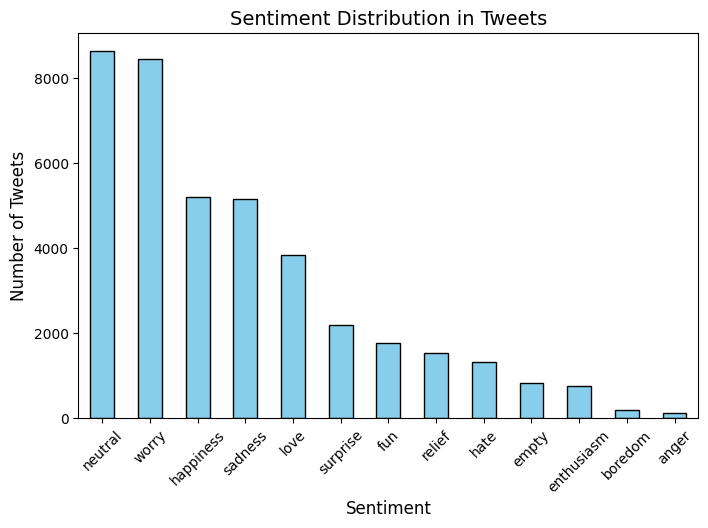

In [8]:
sentiment_counts = df["sentiment"].value_counts()

# ---- Step 4: Visualization (Bar Chart) ----
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Sentiment Distribution in Tweets", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [9]:
# Data preprocessing function

def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [10]:
df['content'] = df['content'].apply(lambda x: cleanResume(str(x)))

In [11]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [12]:
df.head()

,sentiment,content
0,2,i know i was listenin to bad habit earlier an...
1,10,Layin n bed with a headache ughhhh waitin on y...
2,10,Funeral ceremony gloomy friday
3,3,wants to hang out with friends SOON
4,8,We want to trade with someone who has Houston...


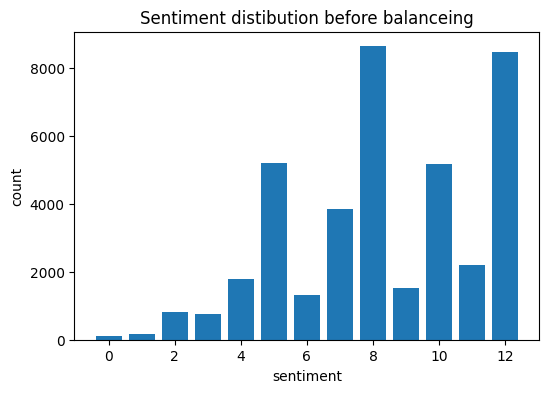

In [13]:
plt.figure(figsize=(6,4))
plt.bar(Counter(df['sentiment']).keys(), Counter(df['sentiment']).values())
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title("Sentiment distibution before balanceing")
plt.show()

In [14]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df['content'])
# vocab_size = len(tokenizer.word_index) + 1
# max_length = 100
# X = tokenizer.texts_to_sequences(df['content'])
# X = pad_sequences(X, maxlen=max_length)
# y = df['sentiment'].values

In [18]:
# Prepare features and labels
requiredText = df['content'].values   # Text data
requiredTarget = df['sentiment'].values  # Encoded labels

In [19]:
# Feature extraction using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500
)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print("Shape of TF-IDF matrix:", WordFeatures.shape)

Shape of TF-IDF matrix: (40000, 1500)


In [21]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(WordFeatures, requiredTarget)

In [22]:
import joblib
print(joblib.dump(le, 'RS_LabelEncoder.pkl'))
joblib.dump(word_vectorizer, 'RS_Model_Vectorizer.pkl')

['RS_LabelEncoder.pkl']


['RS_Model_Vectorizer.pkl']

Text(0.5, 1.0, 'Sentiment distibution after balanceing')

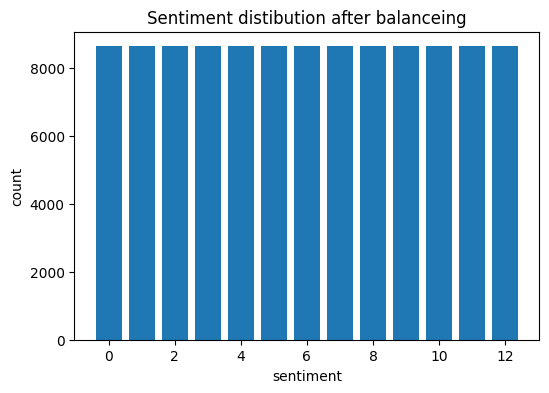

In [23]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title("Sentiment distibution after balanceing")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [25]:
 # randomforest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model_rdm = RandomForestClassifier()
model_rdm.fit(X_train, y_train)
y_pred = model_rdm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1745
           1       0.95      0.99      0.97      1758
           2       0.66      0.95      0.78      1728
           3       0.88      0.94      0.91      1735
           4       0.88      0.93      0.91      1751
           5       0.71      0.67      0.69      1747
           6       0.89      0.95      0.92      1741
           7       0.80      0.81      0.80      1662
           8       0.43      0.30      0.35      1699
           9       0.87      0.92      0.90      1735
          10       0.69      0.66      0.67      1711
          11       0.88      0.87      0.87      1718
          12       0.46      0.33      0.38      1729

    accuracy                           0.79     22459
   macro avg       0.78      0.79      0.78     22459
weighted avg       0.78      0.79      0.78     22459



In [35]:
# Extratreeclassifire
from sklearn.ensemble import ExtraTreesClassifier
model_ext = ExtraTreesClassifier()
model_ext.fit(X_train, y_train)
y_pred = model_ext.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1745
           1       0.95      0.99      0.97      1758
           2       0.66      0.95      0.78      1728
           3       0.89      0.94      0.92      1735
           4       0.92      0.93      0.93      1751
           5       0.72      0.67      0.69      1747
           6       0.92      0.95      0.93      1741
           7       0.80      0.81      0.81      1662
           8       0.42      0.35      0.38      1699
           9       0.89      0.92      0.91      1735
          10       0.73      0.65      0.69      1711
          11       0.91      0.86      0.89      1718
          12       0.47      0.39      0.43      1729

    accuracy                           0.80     22459
   macro avg       0.79      0.80      0.79     22459
weighted avg       0.79      0.80      0.79     22459

Accuracy: 0.7974531368271072


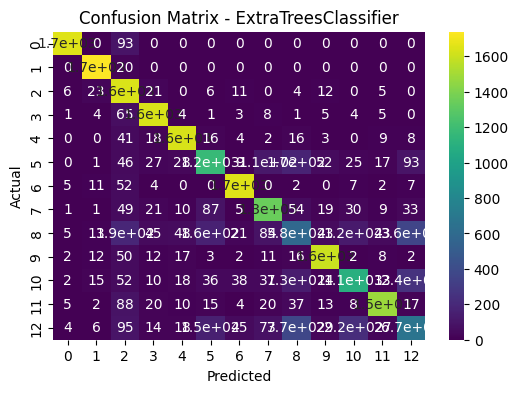

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.title("Confusion Matrix - ExtraTreesClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
print(joblib.dump(model_ext, 'RS_ExtraTreeModel.pkl'))

['RS_ExtraTreeModel.pkl']


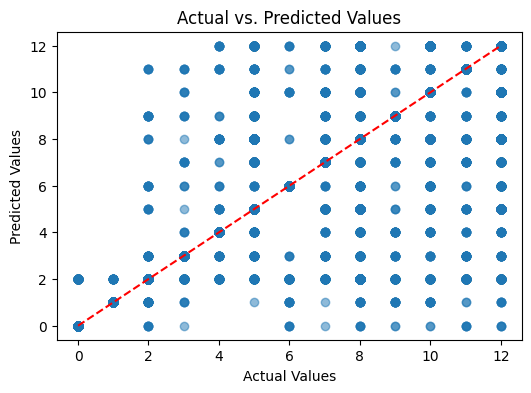

In [36]:
import matplotlib.pyplot as plt
# y_test and y_pred graph
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()



In [39]:
y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)

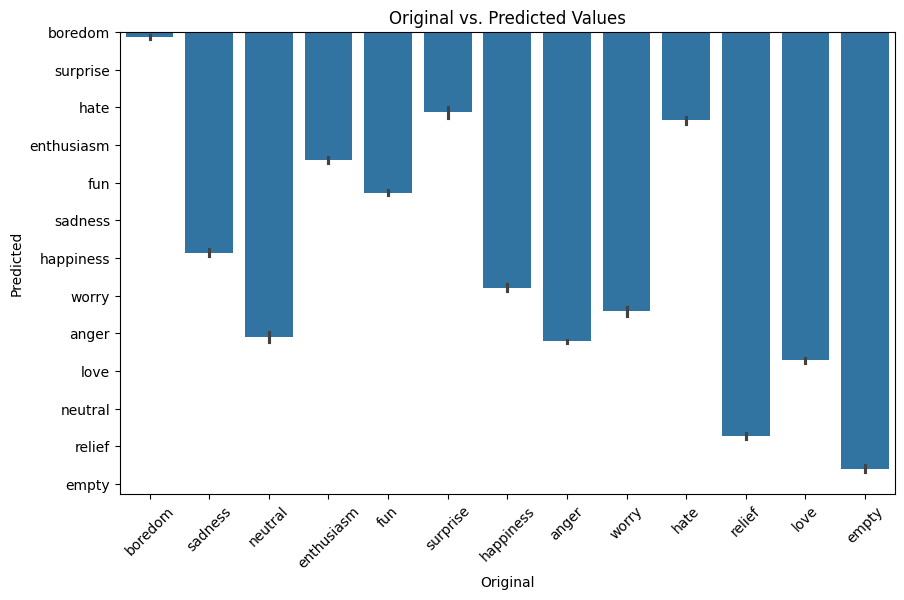

In [40]:
# comparison original and prediction grapg
comparison_df = pd.DataFrame({'Original': y_test, 'Predicted': y_pred})
plt.figure(figsize=(10, 6))
sns.barplot(x='Original', y='Predicted', data=comparison_df)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.title('Original vs. Predicted Values')
plt.xticks(rotation=45)
plt.show()




# Web intigration

In [41]:
pip install streamlit pyngrok

In [49]:
import os

# Create templates directory
templates_dir = 'templates'
os.makedirs(templates_dir, exist_ok=True)

# =========================
# HTML for index.html
# =========================
index_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Emotion Detector</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: linear-gradient(135deg, #6a11cb, #2575fc);
            background-size: 200% 200%;
            animation: gradientShift 8s ease infinite;
            min-height: 100vh;
            display: flex;
            align-items: center;
            justify-content: center;
            font-family: 'Poppins', sans-serif;
            color: #333;
        }
        @keyframes gradientShift {
            0% { background-position: 0% 50%; }
            50% { background-position: 100% 50%; }
            100% { background-position: 0% 50%; }
        }
        .card {
            background: rgba(255, 255, 255, 0.9);
            border: none;
            border-radius: 1rem;
            box-shadow: 0 10px 25px rgba(0, 0, 0, 0.15);
            padding: 2rem;
            width: 100%;
            max-width: 550px;
            transition: transform 0.3s ease;
        }
        .card:hover {
            transform: translateY(-5px);
        }
        h2 {
            text-align: center;
            font-weight: 600;
            margin-bottom: 1.5rem;
            color: #222;
        }
        textarea {
            resize: none;
        }
        button {
            width: 100%;
            border-radius: 10px;
            font-weight: 500;
            transition: 0.3s;
        }
        button:hover {
            background-color: #5a0ecb;
            transform: scale(1.02);
        }
    </style>
</head>
<body>
    <div class="card">
        <h2>✨ Emotion Detection from Text ✨</h2>
        <form action="/predict" method="post">
            <div class="mb-3">
                <label for="user_text" class="form-label">Enter your text below:</label>
                <textarea class="form-control shadow-sm" id="user_text" name="user_text" rows="5" required></textarea>
            </div>
            <button type="submit" class="btn btn-primary py-2">Detect Emotion</button>
        </form>
    </div>
</body>
</html>
"""

# =========================
# HTML for result.html
# =========================
result_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Emotion Result</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: linear-gradient(135deg, #ff9966, #ff5e62);
            background-size: 200% 200%;
            animation: gradientShift 8s ease infinite;
            font-family: 'Poppins', sans-serif;
            display: flex;
            align-items: center;
            justify-content: center;
            height: 100vh;
        }
        @keyframes gradientShift {
            0% { background-position: 0% 50%; }
            50% { background-position: 100% 50%; }
            100% { background-position: 0% 50%; }
        }
        .card {
            background: rgba(255, 255, 255, 0.9);
            border-radius: 1rem;
            padding: 2rem;
            max-width: 600px;
            text-align: center;
            box-shadow: 0 10px 25px rgba(0, 0, 0, 0.15);
        }
        h2 {
            font-weight: 600;
            color: #222;
        }
        #emoji {
            font-size: 4rem;
            margin-top: 1rem;
        }
        .alert {
            font-size: 1.1rem;
        }
        a.btn {
            border-radius: 10px;
            transition: all 0.3s;
        }
        a.btn:hover {
            transform: scale(1.05);
        }
    </style>
</head>
<body>
    <div class="card">
        <h2>🎯 Emotion Prediction Result</h2>
        <div class="alert alert-info mt-3">
            <strong>Input Text:</strong> {{ user_text }}
        </div>
        <div class="alert alert-success mt-3">
            <strong>Predicted Emotion:</strong> {{ prediction }}
            <div id="emoji">
                {% if prediction.lower() == 'love' %}
                    ❤️
                {% elif prediction.lower() == 'fun' %}
                    😂
                {% elif prediction.lower() == 'happy' %}
                    😄
                {% elif prediction.lower() == 'sad' %}
                    😢
                {% elif prediction.lower() == 'angry' %}
                    😡
                {% elif prediction.lower() == 'surprise' %}
                    😲
                {% else %}
                    😐
                {% endif %}
            </div>
        </div>
        <a href="/" class="btn btn-primary mt-3 px-4 py-2">Try Again</a>
    </div>
</body>
</html>
"""

# =========================
# HTML for error.html
# =========================
error_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Error</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background: radial-gradient(circle at top left, #ff6b6b, #d64545);
            font-family: 'Poppins', sans-serif;
            height: 100vh;
            display: flex;
            align-items: center;
            justify-content: center;
        }
        .card {
            background: rgba(255, 255, 255, 0.9);
            padding: 2rem;
            border-radius: 1rem;
            box-shadow: 0 10px 25px rgba(0, 0, 0, 0.15);
            text-align: center;
        }
        h2 {
            color: #b00020;
            font-weight: 600;
        }
        .btn {
            border-radius: 10px;
        }
    </style>
</head>
<body>
    <div class="card">
        <h2>🚨 Error</h2>
        <div class="alert alert-danger mt-3">
            <strong>Error:</strong> {{ error }}
        </div>
        <a href="/" class="btn btn-primary mt-3 px-4 py-2">Back to Home</a>
    </div>
</body>
</html>
"""

# =========================
# Write HTML to files
# =========================
with open(os.path.join(templates_dir, 'index.html'), 'w') as file:
    file.write(index_html)

with open(os.path.join(templates_dir, 'result.html'), 'w') as file:
    file.write(result_html)

with open(os.path.join(templates_dir, 'error.html'), 'w') as file:
    file.write(error_html)

print("✅ Attractive Emotion Detector HTML templates have been created successfully.")


✅ Attractive Emotion Detector HTML templates have been created successfully.


In [50]:
!killall ngrok || echo "no ngrok process"
!rm -rf /root/.ngrok2
!rm -rf /root/.config/ngrok
!rm -rf /usr/local/bin/ngrok


ngrok: no process found
no ngrok process


In [51]:
!wget -q -O ngrok.zip https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok.zip
!mv ngrok /usr/local/bin/


Archive:  ngrok.zip
  inflating: ngrok                   


In [52]:
from pyngrok import ngrok
ngrok.set_auth_token("33kcP12QVAOK55WSkvN3tKTgTzW_5VsPxEbFHQGjZBtp2S65d")


In [53]:
from pyngrok import ngrok
ngrok.set_auth_token("33kcP12QVAOK55WSkvN3tKTgTzW_5VsPxEbFHQGjZBtp2S65d")

public_url = ngrok.connect(5001)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://8231006afc50.ngrok-free.app" -> "http://localhost:5001"


In [57]:
from flask import Flask, request, render_template
import joblib
import os
from pyngrok import ngrok

# Initialize Flask app
app = Flask(__name__)

# Ngrok authentication token (Replace with your own key)
NGROK_AUTH_TOKEN = "33kcP12QVAOK55WSkvN3tKTgTzW_5VsPxEbFHQGjZBtp2S65d"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Start Ngrok tunnel
public_url = ngrok.connect(5001).public_url
print(f"Ngrok tunnel '{public_url}' -> 'http://localhost:5001'")

# Load model, vectorizer, label encoder
try:
    emotion_model = joblib.load('RS_ExtraTreeModel.pkl')  # trained ML/DL model
    vectorizer = joblib.load('RS_Model_Vectorizer.pkl')  # TF-IDF or similar
    label_encoder = joblib.load('RS_LabelEncoder.pkl')  # label encoder
except FileNotFoundError as e:
    print(f"Model or vectorizer file not found: {e}")
    raise

@app.route("/")
def home():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    try:
        user_text = request.form.get("user_text", "")

        if not user_text.strip():
            raise ValueError("Please enter some text to analyze emotion.")

        # Transform input
        X = vectorizer.transform([user_text])

        # Predict emotion
        y_pred = emotion_model.predict(X)[0]
        emotion = label_encoder.inverse_transform([y_pred])[0]

        return render_template("result.html", user_text=user_text, prediction=emotion)

    except Exception as e:
        return render_template("error.html", error=str(e))


if __name__ == "__main__":
    app.run(port=5001)

Ngrok tunnel 'https://b9669762bec4.ngrok-free.app' -> 'http://localhost:5001'
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:33:04] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:33:05] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:33:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:33:42] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:43] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:53] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Oct/2025 20:34:59] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug